# 1 . Importing python libraries

In [2]:
import math, os, sys
import pickle
from glob import glob
import numpy as np
from numpy.random import random, permutation, randn, normal
from matplotlib import pyplot as plt
%matplotlib inline
import PIL
from PIL import Image
import bcolz
from shutil import copyfile
from shutil import move



# 2 . Importing python libraries

In [ ]:
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input,  GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2,l1

# 3 . Define Utility Functions

In [5]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=1, target_size=(224,224), class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size, 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def get_classes(path):
    batches = get_batches('train', shuffle=False, batch_size=1)
    val_batches = get_batches('valid', shuffle=False, batch_size=1)
    #test_batches = get_batches('test', shuffle=False, batch_size=1)
    return (val_batches.classes, batches.classes,to_categorical(val_batches.classes),
            to_categorical(batches.classes),val_batches.filenames, batches.filenames)
           # test_batches.filenames)

def get_data(path, target_size = (224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range (len(batches.classes))])

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname):
    return bcolz.open(fname)[:]

def plot_history(Exp_history):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(Exp_history.history['acc'])
    plt.plot(Exp_history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(212)
    plt.plot(Exp_history.history['loss'])
    plt.plot(Exp_history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoches')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig(results_path+'/train_history/Exp_train_history_1.png', bbox_inches='tight')
    plt.show()


def plot_acc(Exp_history):
    plt.figure(1)
    plt.plot(Exp_history.history['acc'])
    plt.plot(Exp_history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig(results_path+'/train_history/Exp_train_history_1.png', bbox_inches='tight')
    plt.show()

# 4. Data preparation and exploration

As provided, the train dataset contains the following categories of driving states:

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

## 4.1 Prepare data directories
 


In [9]:
current_dir = "imgs/"
#PROJECT_HOME_DIR = current_dir
path = current_dir
#test_path = path + 'test/' #We use all the test data
results_path = path + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid'

In [10]:
!ls

dms_majorproject__rtv.ipynb  img_19.jpg  imgs  README.md


In [11]:
#%cd $path
%mkdir "imgs/results"
%mkdir  "imgs/valid"
#%mkdir models

In [12]:
# Creating validation set
#%cd $valid_path
%mkdir "imgs/valid/c0"
%mkdir "imgs/valid/c1"
%mkdir "imgs/valid/c2"
%mkdir "imgs/valid/c3"
%mkdir "imgs/valid/c4"
%mkdir "imgs/valid/c6"
%mkdir "imgs/valid/c7"
%mkdir "imgs/valid/c8"
%mkdir "imgs/valid/c9"
%mkdir "imgs/valid/c10"
#%cd $path


In [14]:
class_labels = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

for i in class_labels:
    print ('label {0} has {1:5d} images'.format(i,len([name for name in os.listdir(train_path+i) 
                                                         if os.path.isfile(os.path.join(train_path+i, name))])))

label c0 has  2489 images
label c1 has  2267 images
label c2 has  2317 images
label c3 has  2346 images
label c4 has  2326 images
label c5 has  2312 images
label c6 has  2325 images
label c7 has  2002 images
label c8 has  1911 images
label c9 has  2129 images


In [15]:
summ = float(0)
for i in class_labels:
    summ = summ +len([name for name in os.listdir(train_path+i) if os.path.isfile(os.path.join(train_path+i, name))])
summ

22424.0

## 4.2 Creating a validation set

In [16]:
# moving ~20% data from train sets to validation sets
for label in class_labels:
    g = glob("imgs/train/"+label+'/*.jpg')
    shuffle = np.random.permutation(g)
    for i in range(400): move(shuffle[i], "imgs/valid/"+label)

In [17]:
new = float(0)
for i in class_labels:
    new = new +len([name for name in os.listdir(train_path+i) if os.path.isfile(os.path.join(train_path+i, name))])
print(new)

18424.0


## 4.3 Create a redundant dataset

In [18]:

%mkdir  "imgs/redundant"

# Creating validation set
#%cd $valid_path
%mkdir "imgs/redundant/c0"
%mkdir "imgs/redundant/c1"
%mkdir "imgs/redundant/c2"
%mkdir "imgs/redundant/c3"
%mkdir "imgs/redundant/c4"
%mkdir "imgs/redundant/c6"
%mkdir "imgs/redundant/c7"
%mkdir "imgs/redundant/c8"
%mkdir "imgs/redundant/c9"

#%cd $path


In [19]:
for label in class_labels:
    g = glob("imgs/train/"+label+'/*.jpg')
    shuffle = np.random.permutation(g)
    for i in range(1200): move(shuffle[i], "imgs/redundant/"+label)

In [20]:
new = float(0)
for i in class_labels:
    new = new +len([name for name in os.listdir(train_path+i) if os.path.isfile(os.path.join(train_path+i, name))])
print(new)

6424.0


# 5 . Visualization


Found 6424 images belonging to 10 classes.


/usr/local/lib/python3.5/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


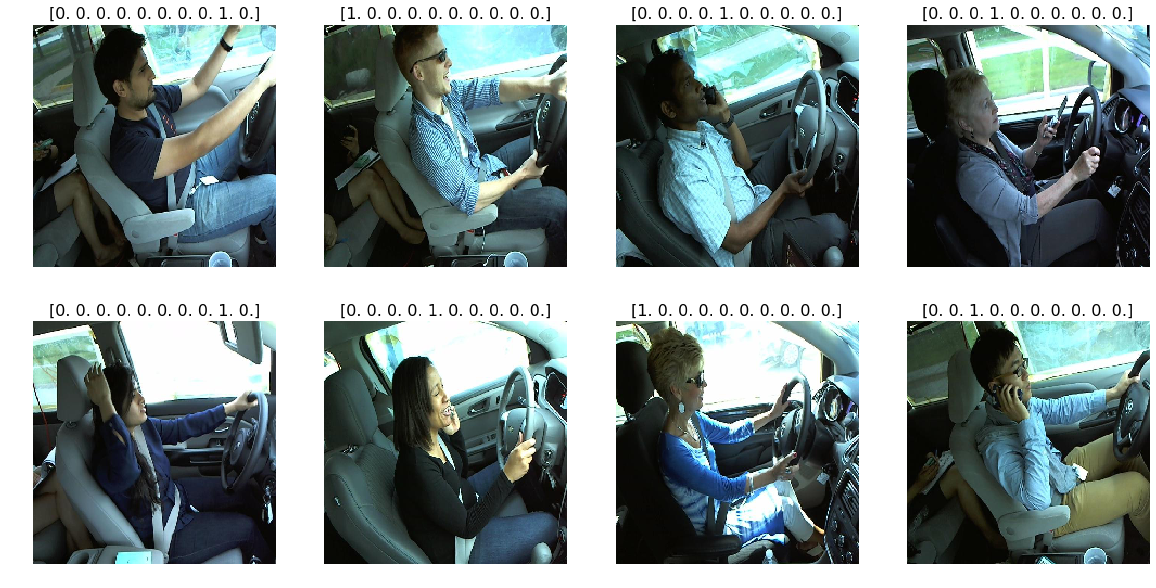

In [21]:
batches = get_batches('train', batch_size=8)
imgs,labels = next(batches)
# Plot randomly 8 images
plots(imgs, titles=labels, figsize=(20,10), rows =2)

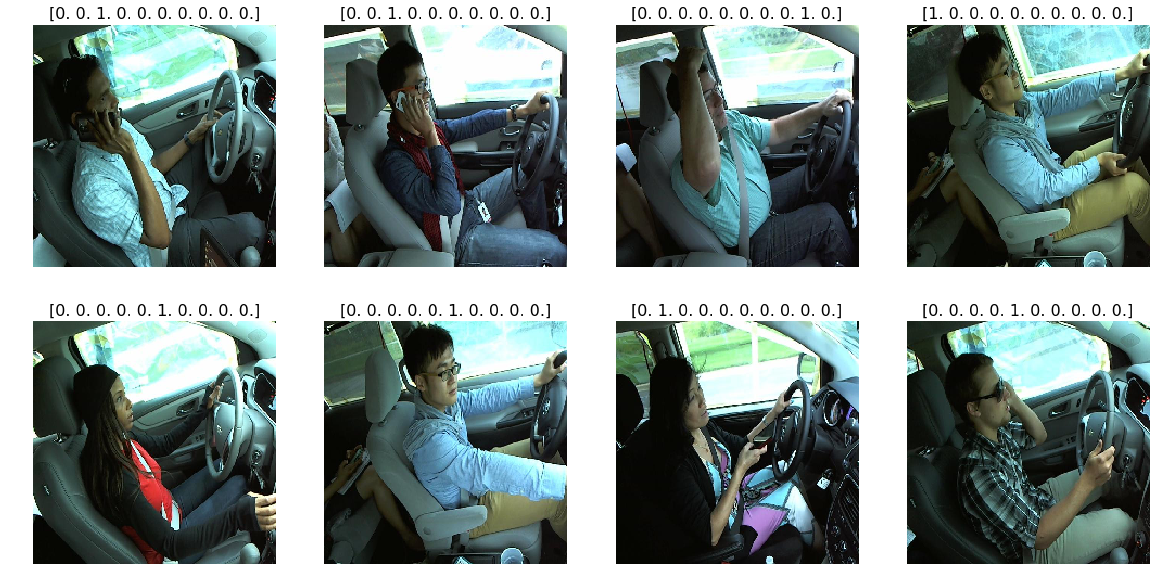

In [22]:
imgs,labels = next(batches)

# Plot randomly 8 images
plots(imgs, titles=labels, figsize=(20,10), rows =2)

## 1.3 Batches preparation

### Batches as direct inputs

<span style="color:red"> WARNING: These lines are only to run once. </span>

In [0]:
# Roll into pixcel matrix
train_data = get_data('train')
valid_data = get_data('valid')

Found 7083 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.


In [0]:
save_array('Distracted-Driver-Detection/imgs/results/train_data.dat', train_data)
save_array('Distracted-Driver-Detection/imgs/results/train_data.dat', train_data)

<span style="color:red">End  WARNING </span>

Loading labels and stored data.

In [0]:
(valid_classes, train_classes, valid_labels, train_labels, valid_filenames, train_filenames) = get_classes(path)
#valid_data = load_array('Distracted-Driver-Detection/imgs/results/valid_data.dat')
#train_data = load_array('Distracted-Driver-Detection/imgs/results/train_data.dat')

Found 7083 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.


## 1.3 Summary


# 2. Experiements

We will start with the simpliest model: a fully connected network with no hidden layer, i.e., linear model. This is to provide a benchmark for subsequence development.

Notes:

- We used  batchnormalization right at the input layer to avoid any domination input values that could skew the output.
- We activated the output with a softmax layer for 10 classes.
- We will 224x224 input shape, as the results we will have 1.5+ million parametters and easily overfitted with a linear model, hence, l2 regularization is used to minimize impact of overfitting.

## 2.1 Linear model

In [0]:
Linear_model = Sequential([
        BatchNormalization(axis=-1, input_shape=(224,224,3)),
        Flatten(),
        Dense(5, activation='softmax')
    ])

Linear_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
Linear_model.summary()            


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 752645    
Total params: 752,657
Trainable params: 752,651
Non-trainable params: 6
_________________________________________________________________


Training 10 epochs.

In [0]:
batch_size=32
Ex1_history = Linear_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5,
                               validation_data =(valid_data,valid_labels))

Train on 7083 samples, validate on 4000 samples
Epoch 1/5
7083/7083 [==============================] - 12s 2ms/step - loss: 0.7609 - acc: 0.8111 - val_loss: 0.1254 - val_acc: 0.9653
Epoch 2/5
7083/7083 [==============================] - 9s 1ms/step - loss: 0.0942 - acc: 0.9706 - val_loss: 0.0543 - val_acc: 0.9848
Epoch 3/5
7083/7083 [==============================] - 9s 1ms/step - loss: 0.0753 - acc: 0.9774 - val_loss: 0.0673 - val_acc: 0.9775
Epoch 4/5
7083/7083 [==============================] - 9s 1ms/step - loss: 0.0459 - acc: 0.9849 - val_loss: 0.0433 - val_acc: 0.9880
Epoch 5/5
7083/7083 [==============================] - 9s 1ms/step - loss: 0.0907 - acc: 0.9728 - val_loss: 0.0652 - val_acc: 0.9825


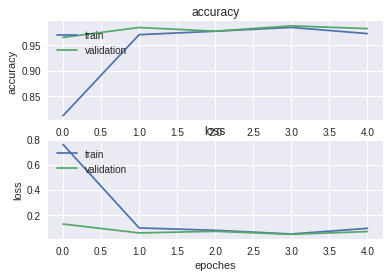

In [0]:
plot_history(Ex1_history)

It can be seen that the linear model with batchnormalization and some l2 regulation actually work pretty well. We can achive validation accuracy of around 94% on the validation dataset. However, the validation accuracy is not stable (even training accuracy is not stable), it means that model will not generalize very well but for starting model, this is very encouraging and it is clearly much better than random guess. 

Next we will try to stablize the validation accuracy with convolutional networks.

## 2.2 Simple convolutional layer network

Next, we experiment a neural network with 2 convolutional layers. This experiment will give us an idea on how this dataset behave under convolutional actions. We will try to overfitting and later adding some regularization or data augmentation.

In [0]:
CNN_simple = Sequential([
            BatchNormalization(input_shape=(224,224,3)),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((3,3)),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(5, activation='softmax')
        ])

CNN_simple.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_simple.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
__________

In [0]:
batch_size=32
Ex2_history = CNN_simple.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                             validation_data =(valid_data,valid_labels))

Train on 7083 samples, validate on 4000 samples
Epoch 1/5
7083/7083 [==============================] - 35s 5ms/step - loss: 0.2502 - acc: 0.9262 - val_loss: 0.0578 - val_acc: 0.9862
Epoch 2/5
7083/7083 [==============================] - 33s 5ms/step - loss: 0.0215 - acc: 0.9972 - val_loss: 0.0199 - val_acc: 0.9960
Epoch 3/5
7083/7083 [==============================] - 33s 5ms/step - loss: 0.0068 - acc: 0.9997 - val_loss: 0.0090 - val_acc: 0.9980
Epoch 4/5
7083/7083 [==============================] - 33s 5ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 0.9985
Epoch 5/5
7083/7083 [==============================] - 33s 5ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 0.9985


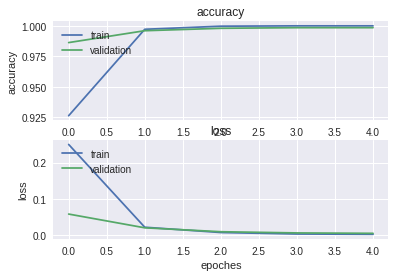

In [0]:
plot_history(Ex2_history)

With 4 epochs, we are able to get to 99% accuracy, however, we are slightly overfitting the model, we will add some reularization or specifically dropout to see if we can stablize the accuracy reading a bit more.

## 2.2 Simple convolutional layer network with dropout

Since we will add dropout, e.i., losing some information in order to simplify the model so that we can generalize better but losing information also cause the network less sophisticated, to have a "good" trade-off, we add one more convolutional layer.

In [0]:
CNN_dropout = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Conv2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(128,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
CNN_dropout.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
#CNN_dropout.summary()

In [0]:
batch_size=32
Ex3_history = CNN_dropout.fit(train_data,train_labels, batch_size=batch_size, epochs=2, 
                              validation_data =(valid_data,valid_labels))

Train on 7083 samples, validate on 4000 samples
Epoch 1/2
7083/7083 [==============================] - 56s 8ms/step - loss: 1.0306 - acc: 0.6352 - val_loss: 0.1480 - val_acc: 0.9748
Epoch 2/2
7083/7083 [==============================] - 54s 8ms/step - loss: 0.2831 - acc: 0.9023 - val_loss: 0.0473 - val_acc: 0.9925


In [0]:
Ex3_history = CNN_dropout.fit(train_data,train_labels, batch_size=batch_size, epochs=3, 
                              validation_data =(valid_data,valid_labels))

Train on 7083 samples, validate on 4000 samples
Epoch 1/3
7083/7083 [==============================] - 54s 8ms/step - loss: 0.1265 - acc: 0.9615 - val_loss: 0.0220 - val_acc: 0.9958
Epoch 2/3
7083/7083 [==============================] - 54s 8ms/step - loss: 0.0788 - acc: 0.9763 - val_loss: 0.0262 - val_acc: 0.9902
Epoch 3/3
7083/7083 [==============================] - 54s 8ms/step - loss: 0.0686 - acc: 0.9804 - val_loss: 0.0135 - val_acc: 0.9970


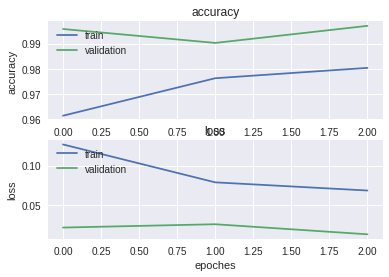

In [0]:
plot_history(Ex3_history)

In [0]:
CNN_dropout.save_weights(path+'models/CNN_dropout.h5')